# Keras with custom loss function

In this notebook we explore how to use keras using its scikit-learn wrapper and a custom loss function.
We struggled with using scikit-learn with custom loss functions, so we think this is the next best thing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import keras
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K

In [2]:
def custom_loss(y_true, y_pred):
    """ RMSE """
    loss = K.mean(((y_true - y_pred)**2), axis=-1)
    loss = K.sqrt(loss)
        
    return loss
  
def create_model():
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(1))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss=custom_loss, optimizer='adam')
    return model

model = KerasRegressor(
    build_fn=create_model, epochs=150, batch_size=10, verbose=0)

### Create some training data

Our dummy data is just a clearsky irradiance curve for the city of Cairo and a constant loss of 80% applied to it with some noise.

Text(0, 0.5, 'Irradiance [W/m²]')

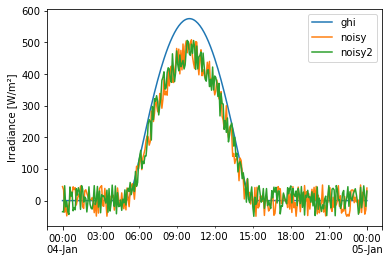

In [3]:
loc = pvlib.location.Location(30.033333, 31.233334)
df = loc.get_clearsky(pd.date_range(
    "2021-01-04", "2021-01-05", freq="5min"))
df = df.drop(["dni" ,"dhi"], axis=1)
df["noisy"] = 0.8*df.ghi + 100 * (np.random.random(len(df.ghi)) - .5)
df["noisy2"] = 0.8*df.ghi + 100 * (np.random.random(len(df.ghi)) - .5)

df.plot()
plt.ylabel("Irradiance [W/m²]")

### Check with sklearn

Since the problem is simple a linear regression model should also be able to solve it. We do this to check if we use the scikit-learn api properly.

(array([[1.22762836]]), 0.0)

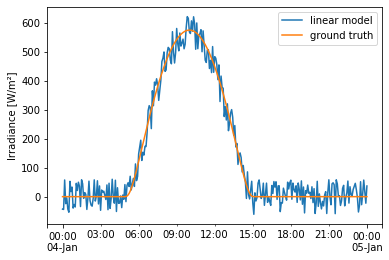

In [4]:
from sklearn.linear_model import LinearRegression

X = df.noisy.values.reshape(-1, 1)
X2 = df.noisy2.values.reshape(-1, 1)
y = df.ghi.values.reshape(-1, 1)

reg = LinearRegression(fit_intercept=False).fit(X, y)


ax = pd.Series(reg.predict(X2).reshape(len(df)),
               index=df.index).plot(label="linear model")
df.ghi.plot(ax=ax, label="ground truth")
plt.ylabel("Irradiance [W/m²]")
plt.legend()

reg.coef_, reg.intercept_

### Check with keras

Now do the same with the keras model. Since we're using the scikit-learn wrapper the model should be able to handle the exact same X and y input variables.

Text(0, 0.5, 'Irradiance [W/m²]')

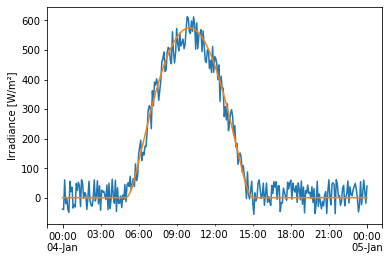

In [5]:
model.fit(X, y)

ax = pd.Series(model.predict(X2).reshape(len(df)),
               index=df.index).plot(label="Keras model")
df.ghi.plot(ax=ax, label="ground truth")
plt.ylabel("Irradiance [W/m²]")

# Loss function to punish underestimation

Now let's make things more interesting by using a different loss function.
Root-mean-square error does punish under- and overestimation the same, let's assume we want to punish underestimation more,

$$ RMSE(p_f, p_m) = \sqrt{\frac{1}{T}\sum_t(p_{f,t}-p_{m,t})^2}$$

we'll use a skewed RMSE to give some weight to underestimation error, eg. $\alpha=2$ and $\beta=1$.

$$ RMSE^{ske}(p_f, p_m) = \sqrt{\frac{1}{T}\left(\alpha\sum_{t\in\Omega_\alpha}(p_{f,t}-p_{m,t})^2 + \beta\sum_{t\in\Omega_\beta}(p_{f,t}-p_{m,t})^2\right)}$$

with

\begin{equation}
\Omega_\alpha = \left\{t : p_{f,t} < p_{m,t}\right\}\\
\Omega_\beta = \left\{t : p_{f,t} > p_{m,t}\right\}
\end{equation}

and $\alpha>\beta$.


In [6]:
def custom_loss(y_true, y_pred):
    alpha, beta = 4.0, 1.0
    omega_a_filter = y_true > y_pred
    omega_a_true = y_true[omega_a_filter]
    omega_a_pred = y_pred[omega_a_filter]
    
    omega_b_filter = y_true < y_pred
    omega_b_true = y_true[omega_b_filter]
    omega_b_pred = y_pred[omega_b_filter]
    
    loss = alpha * K.mean(((omega_a_true - omega_a_pred)**2), axis=-1)
    loss += beta * K.mean(((omega_b_true - omega_b_pred)**2), axis=-1)
    loss = K.sqrt(loss)
        
    return loss
  
def create_model():
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(1))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss=custom_loss, optimizer='adam')
    return model

model2 = KerasRegressor(
    build_fn=create_model, epochs=150, batch_size=10, verbose=0)

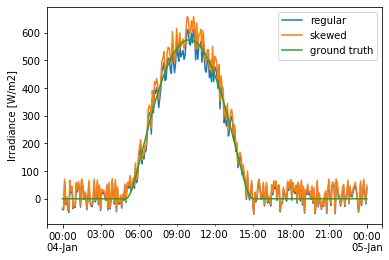

In [7]:
model2.fit(X, y)

ax = pd.Series(model.predict(X2).reshape(len(df)),
               index=df.index).plot(label="regular")
pd.Series(model2.predict(X2).reshape(len(df)),
               index=df.index).plot(ax=ax, label="skewed")
df.ghi.plot(ax=ax, label="ground truth")
plt.ylabel("Irradiance [W/m2]")
plt.legend()

And as expected the model trained on the skewed RMSE understimates the ground truth curve less than the regular model.